# SplitMNIST regression

Here, we consider a binary classification problem and treat it as regression problem using Gaussian Process regression with NNGP kernels.

In [1]:
#import gpytorch
from argparse import Namespace
from datetime import datetime
from hypnettorch.data.cifar100_data import CIFAR100Data
from hypnettorch.data.fashion_mnist import FashionMNISTData
from hypnettorch.data.svhn_data import SVHNData
from hypnettorch.data.special.split_cifar import get_split_cifar_handlers
from hypnettorch.data.special.split_mnist import get_split_mnist_handlers
from hypnettorch.mnets import MLP
from hypnettorch.utils.sim_utils import setup_environment
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, ExpSineSquared
from sklearn.metrics import roc_auc_score
import sys
from time import time
import torch
from torchvision.datasets import KMNIST

# Pretend that notebook is located in base directory of this repo.
curr_dir = os.path.basename(os.path.abspath(os.curdir))
base_dir = os.path.abspath('../..')
if curr_dir == 'nngp' and base_dir != sys.path[0]:
    sys.path.insert(0, base_dir)
    
from utils import notebook as nutils
from nngp.nngp import inference_with_isotropic_gaussian_ll, gen_inference_kernels, \
    cholesky_adaptive_noise
from utils.plotting import heatmap
from utils.misc import eval_grid_2d, calc_regression_acc

from IPython.display import display, Markdown, Latex
#display(Markdown('*some markdown* $\phi$'))

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Create output directory and other helpers.
config = Namespace()
config.out_dir = './out/split_mnist/run_' + \
    datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
config.loglevel_info = False
config.random_seed = 42
config.use_cuda = False # CPU usually faster for simple problems.
config.deterministic_run = True
# Delete file from previous tutorial session:
if os.path.exists(config.out_dir):
    shutil.rmtree(config.out_dir)
device, writer, logger = setup_environment(config, logger_name='mnist_logger')

Created output folder ./out/split_mnist/run_2022-01-25_11-29-40.
01/25/2022 11:29:40 AM - INFO - Using cuda: False


### Create SpliMNIST dataloader

In [2]:
use_cifar = False

if use_cifar:
    sc_dhandlers = get_split_cifar_handlers('../datasets',
        use_one_hot=False, validation_size=0, 
        use_data_augmentation=False, use_cutout=False,
        num_classes_per_task=2, num_tasks=5)
    
    # In-distribution data.
    ind_index = 0
    data = sc_dhandlers[ind_index]

    # OOD data.
    ood_dhandlers = sc_dhandlers[:ind_index] + \
        sc_dhandlers[ind_index+1:]
    
    cifar100 = CIFAR100Data('../datasets')
    ood_dhandlers.append(cifar100)
    
    svhn = SVHNData('../datasets')
    ood_dhandlers.append(svhn)
else:
    sm_dhandlers = get_split_mnist_handlers('../datasets',
                                            use_one_hot=False,
                                            validation_size=0,
                                            use_torch_augmentation=False,
                                            num_classes_per_task=2, 
                                            num_tasks=5,
                                            trgt_padding=None)

    # In-distribution data.
    ind_index = 1
    data = sm_dhandlers[ind_index]

    # OOD data.
    ood_dhandlers = sm_dhandlers[:ind_index] + \
        sm_dhandlers[ind_index+1:]

    fmnist = FashionMNISTData('../datasets')
    ood_dhandlers.append(fmnist)

    #kmnist = KMNIST('../datasets', train=False, download=True)
    #ood_dhandlers.append(kmnist)

n_feature = int(np.prod(data.in_shape))
# Uniform noise.
rand = np.random.RandomState(42)
unif_X = rand.rand(1000, n_feature)
#ood_dhandlers.append(('Uniform noise [0, 1]', unif_X))

rand = np.random.RandomState(42)
ind_var = data.get_train_inputs().std(axis=0).mean()**2
unif_range = np.sqrt(12 * ind_var)
unif_scaled_X = rand.rand(1000, n_feature) * unif_range
#ood_dhandlers.append(('Uniform noise [0, %f]' % \
#                      (unif_range), unif_scaled_X))

Creating 5 data handlers for SplitMNIST tasks ...
Reading MNIST dataset ...
Elapsed time to read dataset: 0.174488 sec
Created SplitMNIST task with labels [0, 1] and 12665 train, 2115 test and 0 val samples.
Reading MNIST dataset ...
Elapsed time to read dataset: 0.161692 sec
Created SplitMNIST task with labels [2, 3] and 12089 train, 2042 test and 0 val samples.
Reading MNIST dataset ...
Elapsed time to read dataset: 0.161880 sec
Created SplitMNIST task with labels [4, 5] and 11263 train, 1874 test and 0 val samples.
Reading MNIST dataset ...
Elapsed time to read dataset: 0.162091 sec
Created SplitMNIST task with labels [6, 7] and 12183 train, 1986 test and 0 val samples.
Reading MNIST dataset ...
Elapsed time to read dataset: 0.162174 sec
Created SplitMNIST task with labels [8, 9] and 11800 train, 1983 test and 0 val samples.
Creating data handlers for SplitMNIST tasks ... Done


### Reduce training set size

To reduce the size of the kernel matrices we shrink the training set sizes. Note, the a single SplitMNIST task commonly does not require many samples.

In [3]:
def shrink_train_set(dh, new_train_size=1000):
    n_train = dh.num_train_samples
    train_inds = dh._data['train_inds']
    assert train_inds.size == n_train

    if n_train > new_train_size:
        # Ensure that the chosen training set is independent of the
        # configured random seed.
        rand = np.random.RandomState(42)
        new_train_inds = rand.choice(train_inds,
            size=new_train_size, replace=False)
        new_train_inds = np.sort(new_train_inds)
        assert new_train_inds.size == np.unique(new_train_inds).size
        dh._data['train_inds'] = new_train_inds

        display('The training dataset was reduced to %d.' % (new_train_size))

shrink_train_set(data)
print(np.unique(data.get_train_outputs(), return_counts=True))

'The training dataset was reduced to 1000.'

(array([0, 1]), array([482, 518]))


### Use -1 / 1 as regression targets

Instead of using class labels, we use $-1$ and $1$ as target outputs.

In [4]:
n = data.num_classes
assert n % 2 == 0

data._data['out_data'][data._data['out_data'] < n // 2] = -1
data._data['out_data'][data._data['out_data'] >= 0] = 1
print(np.unique(data._data['out_data'], return_counts=True))

(array([-1,  1]), array([6990, 7141]))


In [5]:
X_train_np = data.get_train_inputs()
Y_train_np = data.get_train_outputs()

X_test_np = data.get_test_inputs()
Y_test_np = data.get_test_outputs()

X_train = data.input_to_torch_tensor(X_train_np, mode='train', device=device)
Y_train = data.output_to_torch_tensor(Y_train_np, mode='train', device=device)

X_test = data.input_to_torch_tensor(X_test_np, mode='inference', device=device)
Y_test = data.output_to_torch_tensor(Y_test_np, mode='inference', device=device)

### Likelihood variance

We have to pick (or optimize) a likelihood variance $\sigma^2$. For this artificial regression task, the choice is kind of arbitrary.

In [6]:
likelihood_var = 1e-2

### Helper functions

In [7]:
def compute_accuracy(trgt, pred):
    if len(pred.shape) == 1:
        pred = pred.view(-1, 1)

    lbl = trgt > 0
    pred_lbl = pred > 0
    
    assert np.all(np.equal(lbl.shape, pred_lbl.shape))
    
    return torch.sum(lbl == pred_lbl) / lbl.shape[0] * 100.

def calc_auroc_binary_regression(ind_uncertainties, ood_uncertainties):
    if isinstance(ind_uncertainties, torch.Tensor):
        ind_uncertainties = ind_uncertainties.detach().cpu().numpy()
    if isinstance(ood_uncertainties, torch.Tensor):
        ood_uncertainties = ood_uncertainties.detach().cpu().numpy()
    
    y_true = [0]*len(ind_uncertainties) + [1]*len(ood_uncertainties)
    y_score = ind_uncertainties.tolist() + ood_uncertainties.tolist()
    auroc = roc_auc_score(y_true, y_score)
        
    return auroc

### Using a GP with standard kernel

In [8]:
%%script false --no-raise-error # Do not execute cell.

ls = 10
display(Markdown('**Length-scale** %f' % (ls)))
#kernel = ExpSineSquared(length_scale=1, periodicity=1,
#                        length_scale_bounds='fixed',
#                        periodicity_bounds='fixed')
#kernel = DotProduct(sigma_0=1, sigma_0_bounds="fixed")
kernel = RBF(length_scale=ls, length_scale_bounds="fixed")
gpr = GaussianProcessRegressor(kernel=kernel, alpha=likelihood_var, 
                               random_state=42).fit(X_train_np, Y_train_np)

gp_train_mean, gp_train_std = gpr.predict(X_train_np, return_std=True)
print('train ', X_train_np.shape, 'mean', gp_train_mean.min(), gp_train_mean.max(), 
      'std', gp_train_std.min(), gp_train_std.max())

display(Markdown('Training accuracy %f' % (compute_accuracy(Y_train,
    torch.from_numpy(gp_train_mean)))))


gp_test_mean, gp_test_std = gpr.predict(X_test_np, return_std=True)
display(Markdown('**Test accuracy** %f' % (compute_accuracy(Y_test,
    torch.from_numpy(gp_test_mean)))))


split_mnist_aurocs = []
for i, odh in enumerate(ood_dhandlers):
    if isinstance(odh, KMNIST):
        X_ood_test = odh.data.view(odh.data.shape[0], -1) / 255.
        X_ood_test_np = X_ood_test.cpu().numpy()
        ident = 'KMNIST'
    elif isinstance(odh, tuple):
        X_ood_test_np = odh[1]
        X_ood_test = torch.from_numpy(X_ood_test_np).to(device)
        ident = odh[0]
    else:
        X_ood_test_np = odh.get_test_inputs()
        X_ood_test = odh.input_to_torch_tensor(X_ood_test_np, mode='inference',
                                               device=device)
        ident = odh.get_identifier()
    
    ood_test_mean, ood_test_std = gpr.predict(X_ood_test_np, return_std=True)
    #auroc_std = calc_auroc_binary_regression( \
    #            torch.from_numpy(gp_test_std),
    #            torch.from_numpy(ood_test_std))
    auroc = calc_auroc_binary_regression( \
                torch.from_numpy(gp_test_std**2),
                torch.from_numpy(ood_test_std**2))
    #display(Markdown('AUROC (STD) %s is %f' % (ident, auroc_std)))
    display(Markdown('**AUROC** %s is %f' % (ident, auroc)))
    
    if 'Split' in ident:
        split_mnist_aurocs.append(auroc)

display(Markdown('Mean **AUROC** for Split-Tasks is %f' % \
                 (np.mean(split_mnist_aurocs))))

### Using NNGP kernels

In [9]:
## Define MLP architectures to be considered
num_mc = 100000

nngp_kernel_properties = [
    ### Relu - Analytic ###
    {'name': 'ana_relu_1l', 'type': 'analytic',
     'params': {'n_layer': 1, 'nonlinearity': torch.nn.ReLU(), 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
    {'name': 'ana_relu_2l', 'type': 'analytic',
     'params': {'n_layer': 2, 'nonlinearity': torch.nn.ReLU(), 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
    {'name': 'ana_relu_4l', 'type': 'analytic',
     'params': {'n_layer': 4, 'nonlinearity': torch.nn.ReLU(), 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
    ### Error Function - Analytic ###
    {'name': 'ana_erf_1l', 'type': 'analytic',
     'params': {'n_layer': 1, 'nonlinearity': torch.erf, 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
    {'name': 'ana_erf_2l', 'type': 'analytic',
     'params': {'n_layer': 2, 'nonlinearity': torch.erf, 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
    {'name': 'ana_erf_4l', 'type': 'analytic',
     'params': {'n_layer': 4, 'nonlinearity': torch.erf, 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
    ### Sigmoid ###
    #{'name': 'sigmoid_1l', 'type': 'mc',
    # 'params': {'n_layer': 1, 'nonlinearity': torch.nn.Sigmoid(), 'sigma2_w': 1., 'sigma2_b': 1.},
    # 'kernel_params': {'num_samples': num_mc}},
    #{'name': 'sigmoid_2l', 'type': 'mc',
    # 'params': {'n_layer': 2, 'nonlinearity': torch.nn.Sigmoid(), 'sigma2_w': 1., 'sigma2_b': 1.},
    # 'kernel_params': {'num_samples': num_mc}},
    #{'name': 'sigmoid_4l', 'type': 'mc',
    # 'params': {'n_layer': 4, 'nonlinearity': torch.nn.Sigmoid(), 'sigma2_w': 1., 'sigma2_b': 1.},
    # 'kernel_params': {'num_samples': num_mc}},
    ### Tanh ###
    #{'name': 'tanh_1l', 'type': 'mc',
    # 'params': {'n_layer': 1, 'nonlinearity': torch.nn.Tanh(), 'sigma2_w': 1., 'sigma2_b': 1.},
    # 'kernel_params': {'num_samples': num_mc}},
    #{'name': 'tanh_2l', 'type': 'mc',
    # 'params': {'n_layer': 2, 'nonlinearity': torch.nn.Tanh(), 'sigma2_w': 1., 'sigma2_b': 1.},
    # 'kernel_params': {'num_samples': num_mc}},
    #{'name': 'tanh_4l', 'type': 'mc',
    # 'params': {'n_layer': 4, 'nonlinearity': torch.nn.Tanh(), 'sigma2_w': 1., 'sigma2_b': 1.},
    # 'kernel_params': {'num_samples': num_mc}},
    ### Cos ###
    {'name': 'ana_cos_1l', 'type': 'analytic',
     'params': {'n_layer': 1, 'nonlinearity': torch.cos, 'sigma2_w': 1., 'sigma2_b': 1.},
     'kernel_params': {}},
     {'name': 'ana_cos_1l_sw_medium', 'type': 'analytic',
     'params': {'n_layer': 1, 'nonlinearity': torch.cos, 'sigma2_w': 10., 'sigma2_b': 1.},
     'kernel_params': {}},
    {'name': 'ana_cos_1l_sw_large', 'type': 'analytic',
     'params': {'n_layer': 1, 'nonlinearity': torch.cos, 'sigma2_w': 100., 'sigma2_b': 1.},
     'kernel_params': {}},
]

std_kernel_properties = [
    ### Standard Kernels ###
    #{'name': 'rbf_ls_normal', 'type': 'none',
    # 'params': {'kernel': 'rbf'},
    # 'kernel_params': {'length_scale': 1.}},
    #{'name': 'rbf_ls_small', 'type': 'none',
    # 'params': {'kernel': 'rbf'},
    # 'kernel_params': {'length_scale': .1}},
    {'name': 'rbf_ls_medium', 'type': 'none',
     'params': {'kernel': 'rbf'},
     'kernel_params': {'length_scale': 5.}},
    #{'name': 'rbf_ls_big', 'type': 'none',
    # 'params': {'kernel': 'rbf'},
    # 'kernel_params': {'length_scale': 10.}},
]

In [10]:
#%%script false --no-raise-error # Do not execute cell.

with torch.no_grad():
    nutils.compute_kernel_values(nngp_kernel_properties, X_test, X_train, Y_train,
                                 nutils.determine_mlp_kernel_func, test_bs=500,
                                 out_dir=config.out_dir, try_inference=False)
    nutils.compute_kernel_values(std_kernel_properties, X_test, X_train, Y_train,
                                 nutils.determine_classic_kernel_func, test_bs=500,
                                 out_dir=config.out_dir, try_inference=False)

kernel_properties = nngp_kernel_properties + std_kernel_properties

Investiagting **ana_relu_1l**

  0%|          | 0/2042 [00:00<?, ?it/s]

Kernel computation took 3.213982 seconds.

Investiagting **ana_relu_2l**

  0%|          | 0/2042 [00:00<?, ?it/s]

Kernel computation took 3.145480 seconds.

Investiagting **ana_relu_4l**

  0%|          | 0/2042 [00:00<?, ?it/s]

Kernel computation took 3.253083 seconds.

Investiagting **ana_erf_1l**

  0%|          | 0/2042 [00:00<?, ?it/s]

Kernel computation took 3.129570 seconds.

Investiagting **ana_erf_2l**

  0%|          | 0/2042 [00:00<?, ?it/s]

Kernel computation took 3.140512 seconds.

Investiagting **ana_erf_4l**

  0%|          | 0/2042 [00:00<?, ?it/s]

Kernel computation took 3.229884 seconds.

Investiagting **ana_cos_1l**

  0%|          | 0/2042 [00:00<?, ?it/s]

Kernel computation took 4.700256 seconds.

Investiagting **ana_cos_1l_sw_medium**

  0%|          | 0/2042 [00:00<?, ?it/s]

Kernel computation took 4.664198 seconds.

Investiagting **ana_cos_1l_sw_large**

  0%|          | 0/2042 [00:00<?, ?it/s]

Kernel computation took 4.712267 seconds.

Investiagting **rbf_ls_medium**

  0%|          | 0/2042 [00:00<?, ?it/s]

Kernel computation took 2.883824 seconds.

In [11]:
%%script false --no-raise-error # Do not execute cell.

nutils.load_kernel_values(nngp_kernel_properties,
    out_dir='./out/split_mnist/all_kernels', device=device)

nutils.load_kernel_values(std_kernel_properties,
    out_dir='./out/split_mnist/all_kernels', device=device)

kernel_properties = nngp_kernel_properties + std_kernel_properties

In [12]:
display(Markdown('All models use the likelihood **%f** ...' % (likelihood_var))) 

with torch.no_grad():
    for i, k_props in enumerate(kernel_properties):    
        display(Markdown('Working on **%s** ...' % (k_props['name']))) 

        if 'K_train' not in k_props.keys():
            continue

        K_train = k_props['K_train']
        K_test = k_props['K_test']
        K_all = k_props['K_all']

        try:
            train_mean, train_var = inference_with_isotropic_gaussian_ll( \
                Y_train, K_train, torch.diagonal(K_train), K_train, \
                var=likelihood_var)
            display(Markdown('Training accuracy: %.2f%%' \
                  % compute_accuracy(Y_train, train_mean)))
        except:
            display(Markdown('**WARN** Could not compute training accuracy for **%s**.' \
                             % (likelihood_var, k_props['name'])))

        try:
            test_mean, test_var = inference_with_isotropic_gaussian_ll( \
                Y_train, K_train, K_test, K_all, var=likelihood_var)
        except:
            L, ll_var = cholesky_adaptive_noise(K_train, var=likelihood_var, var_step=1.1)
            display(Markdown('**WARN** Have to use higher ll variance %f for **%s**.' \
                             % (ll_var, k_props['name'])))
            test_mean, test_var = inference_with_isotropic_gaussian_ll( \
                Y_train, K_train, K_test, K_all, L_mat=L, var=ll_var)

        def check_nan(tensor, ident):
            if torch.any(torch.isnan(tensor)):
                nan_mask = torch.isnan(tensor)
                display(Markdown('**%d NaN values in %s.**' \
                        % (nan_mask.sum(), ident)))
                tensor[nan_mask] = 0

        check_nan(test_mean, 'predictive mean')
        check_nan(test_var, 'predictive variance')

        display(Markdown('**Test accuracy**: %.2f%%' \
              % compute_accuracy(Y_test, test_mean)))

        k_props['test_mean'] = test_mean
        k_props['test_var'] = test_var
        k_props['ood'] = {}
        
        split_aurocs = []   
        n_splits = 0
        for i, odh in enumerate(ood_dhandlers):
            if isinstance(odh, KMNIST):
                X_ood_test = odh.data.view(odh.data.shape[0], -1) / 255.
                X_ood_test_np = X_ood_test.cpu().numpy()
                ident = 'KMNIST'
            elif isinstance(odh, tuple):
                X_ood_test_np = odh[1]
                X_ood_test = torch.from_numpy(X_ood_test_np).float().to(device)
                ident = odh[0]
            else:
                X_ood_test_np = odh.get_test_inputs()
                X_ood_test = odh.input_to_torch_tensor(X_ood_test_np, mode='inference',
                                                       device=device)
                ident = odh.get_identifier()
                if 'Split' in ident:
                    ident = '%s_%d' % (ident, n_splits)
                    n_splits += 1

            try:
                if k_props['type'] == 'none':
                    kernel_func = nutils.determine_classic_kernel_func(k_props)
                else:
                    kernel_func = nutils.determine_mlp_kernel_func(k_props)
                
                _, K_test_ood, K_all_ood = \
                    gen_inference_kernels(X_train, X_ood_test, kernel_func,
                                          compute_K_train=False, full_K_test=False)

                ood_test_mean, ood_test_var = inference_with_isotropic_gaussian_ll( \
                    Y_train, K_train, K_test_ood, K_all_ood, var=likelihood_var)

                check_nan(ood_test_mean, 'predictive mean on OOD')
                check_nan(ood_test_var, 'predictive variance on OOD')

                auroc = calc_auroc_binary_regression( \
                    test_var, ood_test_var)
                display(Markdown('**AUROC** %s is %f' % (ident, auroc)))
                
                if 'Split' in ident:
                    split_aurocs.append(auroc)
                
                res = {}
                res['auroc'] = auroc
                res['ood_test_mean'] = ood_test_mean
                res['ood_test_var'] = ood_test_var
                res['ood_index'] = i
                
                k_props['ood'][ident] = res
            except:
                print(ident, ' failed')
                continue
                
        if len(split_aurocs) > 0:
            display(Markdown('Mean **AUROC** for Split-Tasks is %f' % \
                             (np.mean(split_aurocs))))

All models use the likelihood **0.010000** ...

Working on **ana_relu_1l** ...

Training accuracy: 99.40%

**Test accuracy**: 97.80%

**AUROC** SplitMNIST_0 is 0.703505

**AUROC** SplitMNIST_1 is 0.907820

**AUROC** SplitMNIST_2 is 0.914777

**AUROC** SplitMNIST_3 is 0.889739

**AUROC** Fashion-MNIST is 0.993514

Mean **AUROC** for Split-Tasks is 0.853960

Working on **ana_relu_2l** ...

Training accuracy: 99.10%

**Test accuracy**: 97.80%

**AUROC** SplitMNIST_0 is 0.705405

**AUROC** SplitMNIST_1 is 0.909162

**AUROC** SplitMNIST_2 is 0.911424

**AUROC** SplitMNIST_3 is 0.891617

**AUROC** Fashion-MNIST is 0.988599

Mean **AUROC** for Split-Tasks is 0.854402

Working on **ana_relu_4l** ...

Training accuracy: 97.70%

**Test accuracy**: 97.75%

**AUROC** SplitMNIST_0 is 0.698873

**AUROC** SplitMNIST_1 is 0.904420

**AUROC** SplitMNIST_2 is 0.900873

**AUROC** SplitMNIST_3 is 0.887117

**AUROC** Fashion-MNIST is 0.971069

Mean **AUROC** for Split-Tasks is 0.847820

Working on **ana_erf_1l** ...

Training accuracy: 99.30%

**Test accuracy**: 97.60%

**AUROC** SplitMNIST_0 is 0.710482

**AUROC** SplitMNIST_1 is 0.909581

**AUROC** SplitMNIST_2 is 0.918221

**AUROC** SplitMNIST_3 is 0.890831

**AUROC** Fashion-MNIST is 0.995249

Mean **AUROC** for Split-Tasks is 0.857279

Working on **ana_erf_2l** ...

Training accuracy: 99.00%

**Test accuracy**: 97.65%

**AUROC** SplitMNIST_0 is 0.718117

**AUROC** SplitMNIST_1 is 0.913705

**AUROC** SplitMNIST_2 is 0.917353

**AUROC** SplitMNIST_3 is 0.895110

**AUROC** Fashion-MNIST is 0.991672

Mean **AUROC** for Split-Tasks is 0.861071

Working on **ana_erf_4l** ...

Training accuracy: 97.70%

**Test accuracy**: 97.70%

**AUROC** SplitMNIST_0 is 0.718276

**AUROC** SplitMNIST_1 is 0.913228

**AUROC** SplitMNIST_2 is 0.910308

**AUROC** SplitMNIST_3 is 0.895445

**AUROC** Fashion-MNIST is 0.976929

Mean **AUROC** for Split-Tasks is 0.859314

Working on **ana_cos_1l** ...

Training accuracy: 99.30%

**Test accuracy**: 97.85%

**AUROC** SplitMNIST_0 is 0.694524

**AUROC** SplitMNIST_1 is 0.903522

**AUROC** SplitMNIST_2 is 0.909437

**AUROC** SplitMNIST_3 is 0.884925

**AUROC** Fashion-MNIST is 0.991829

Mean **AUROC** for Split-Tasks is 0.848102

Working on **ana_cos_1l_sw_medium** ...

Training accuracy: 100.00%

**Test accuracy**: 98.92%

**AUROC** SplitMNIST_0 is 0.708401

**AUROC** SplitMNIST_1 is 0.909308

**AUROC** SplitMNIST_2 is 0.906797

**AUROC** SplitMNIST_3 is 0.877627

**AUROC** Fashion-MNIST is 0.981107

Mean **AUROC** for Split-Tasks is 0.850533

Working on **ana_cos_1l_sw_large** ...

Training accuracy: 100.00%

**Test accuracy**: 98.53%

**AUROC** SplitMNIST_0 is 0.720945

**AUROC** SplitMNIST_1 is 0.912597

**AUROC** SplitMNIST_2 is 0.914363

**AUROC** SplitMNIST_3 is 0.882241

**AUROC** Fashion-MNIST is 0.955313

Mean **AUROC** for Split-Tasks is 0.857536

Working on **rbf_ls_medium** ...

Training accuracy: 100.00%

**Test accuracy**: 99.12%

**AUROC** SplitMNIST_0 is 0.719583

**AUROC** SplitMNIST_1 is 0.912362

**AUROC** SplitMNIST_2 is 0.908840

**AUROC** SplitMNIST_3 is 0.882016

**AUROC** Fashion-MNIST is 0.965626

Mean **AUROC** for Split-Tasks is 0.855700

## 2D uncertainty maps

We consider three images $p_1$, $p_2$ and $p_3$ and the plane spanned by $p_1 - p_3$ and $p_2 - p_3$ with origin $p_3$.

Thus, the plane can be described by two orthogonal vectors $x$ and $y$ of unit length together with the origin $p_3$.

In [13]:
# Which point should be the origin p3?

#setting = 'use_ind_lowest_unc'
setting = 'use_ind_highest_unc'
#setting = 'use_ood_lowest_unc'
#setting = 'use_ood_highest_unc'

In [14]:
def create_grid_basis(p1, p2, p3):
    p1 = p1.squeeze()
    p2 = p2.squeeze()
    p3 = p3.squeeze()
    
    x = p1 - p3
    z = p2 - p3
    
    x_norm = np.sqrt(np.sum(x*x))
    z_norm = np.sqrt(np.sum(z*z))
    
    x /= x_norm
    z /= z_norm
    
    # Vector orthogonal to x.
    y = z - np.sum(x*z) * x
    
    y_norm = np.sqrt(np.sum(y*y))
    y /= y_norm
    
    coords = np.array([
              [np.sum(x*(p1-p3)), np.sum(y*(p1-p3))],
              [np.sum(x*(p2-p3)), np.sum(y*(p2-p3))],
              [0., 0.]])
    
    return (p3, x, y), coords

#inps, trgts = data.next_train_batch(3)
#(p3, x, y), coords = create_grid_basis(inps[0,:], inps[1,:], inps[2,:])

#data.plot_samples('test', inps[2,:].reshape(1, -1))
#data.plot_samples('test', x.reshape(1, -1) + inps[2,:].reshape(1, -1))
#data.plot_samples('test', y.reshape(1, -1) + inps[2,:].reshape(1, -1))

In [15]:
def grid_2d_to_nd(grid2d, bases):
    p3, x, y = bases
    
    grid_nd = p3.reshape(1, -1) + \
        grid2d[:, 0].reshape(-1, 1) * x.reshape(1, -1) + \
        grid2d[:, 1].reshape(-1, 1) * y.reshape(1, -1)
    return grid_nd

#grid_nd = grid_2d_to_nd(grid_X, (p3, x, y))
#grid_nd.shape

In [16]:
# Create 2-dimensional grid.
if setting == 'use_ind_highest_unc':
    grid_X1, grid_X2, grid_X = eval_grid_2d(x_range=(-2, 12), y_range=(-2, 12), res_per_unit=5,
                                            verbose=True)

    heatmap_kwargs = {
        'grid_X': grid_X1,
        'grid_Y': grid_X2,
        'show_title': False,
        'num_levels': 100,
        'log_levels': False,
        'crop': False,
        'xticks': [0, 5, 10],
        'yticks': [0, 5, 10],
        #'data_in': coords,
        #'data_trgt': trgts.squeeze(),
        'out_dir': config.out_dir,
        'ts': 30,
        'lw': 15, 
        'figsize': (12, 7)
    }
elif setting == 'use_ood_lowest_unc':
    grid_X1, grid_X2, grid_X = eval_grid_2d(x_range=(-2, 7), y_range=(-2, 7), res_per_unit=5,
                                            verbose=True)

    heatmap_kwargs = {
        'grid_X': grid_X1,
        'grid_Y': grid_X2,
        'show_title': False,
        'num_levels': 100,
        'log_levels': False,
        'crop': False,
        'xticks': [0, 5],
        'yticks': [0, 5],
        #'data_in': coords,
        #'data_trgt': trgts.squeeze(),
        'out_dir': config.out_dir,
        'ts': 30,
        'lw': 15, 
        'figsize': (12, 7)
    }
else:
    grid_X1, grid_X2, grid_X = eval_grid_2d(x_range=(-1, 9), y_range=(-1, 9), res_per_unit=5,
                                            verbose=True)

    heatmap_kwargs = {
        'grid_X': grid_X1,
        'grid_Y': grid_X2,
        'show_title': False,
        'num_levels': 100,
        'log_levels': False,
        'crop': False,
        'xticks': [0, 4, 8],
        'yticks': [0, 4, 8],
        #'data_in': coords,
        #'data_trgt': trgts.squeeze(),
        'out_dir': config.out_dir,
        'ts': 30,
        'lw': 15, 
        'figsize': (12, 7)
    }

Grid resolution: 70 x 70.


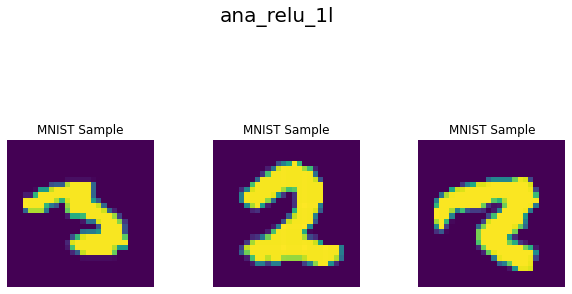

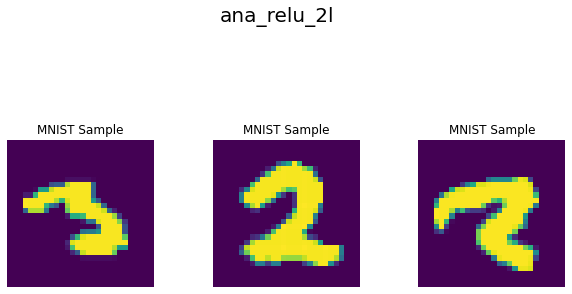

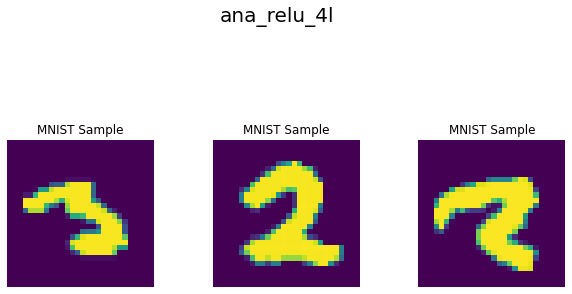

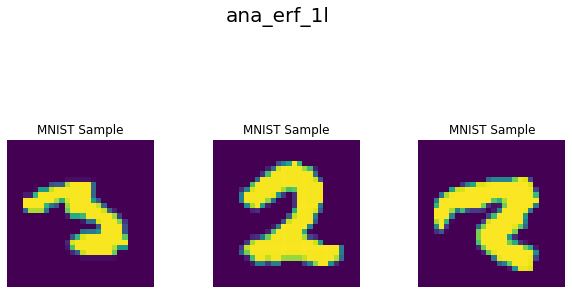

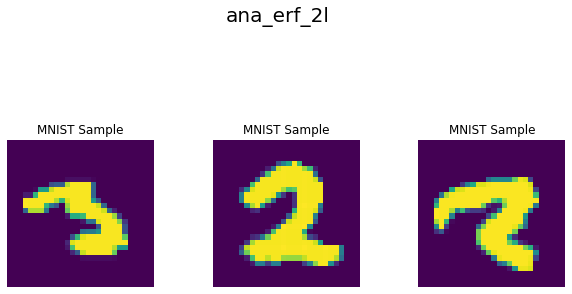

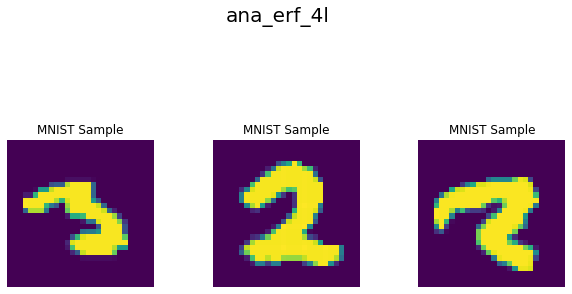

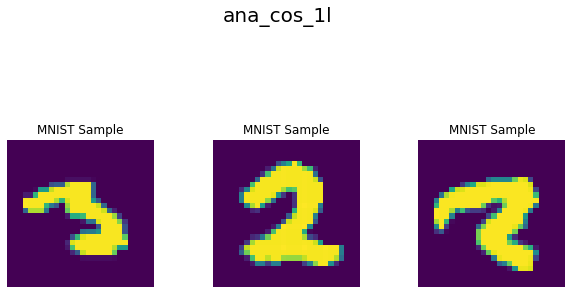

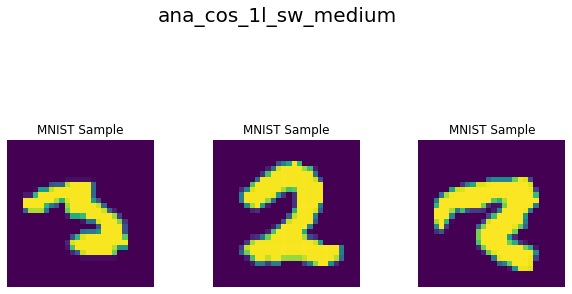

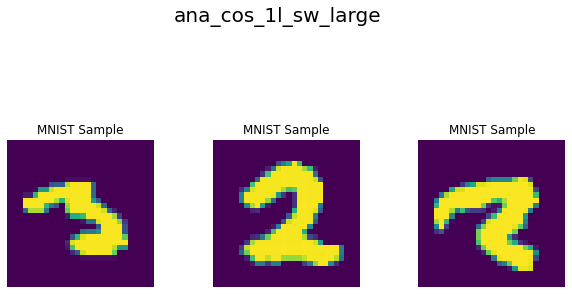

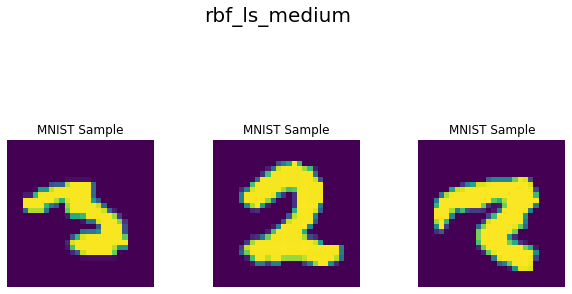

In [17]:
for i, k_props in enumerate(kernel_properties):   
    # Take lowest/highest uncertainty OOD point.
    ood_ident = 'Fashion-MNIST'
    #ood_ident = 'SplitMNIST_0'
    ood_ind = k_props['ood'][ood_ident]['ood_index']
    ood_uncs = k_props['ood'][ood_ident]['ood_test_var']
    test_min = ood_uncs.argmin()
    test_max = ood_uncs.argmax()
    
    ood_dh = ood_dhandlers[ood_ind]
    p3_min_ood = ood_dh.get_test_inputs()[test_min, :]
    p3_max_ood = ood_dh.get_test_inputs()[test_max, :]
    
    test_ind_min = k_props['test_var'].argmin()
    test_ind_max = k_props['test_var'].argmax()
    p3_min_ind = data.get_test_inputs()[test_ind_min, :]
    p3_max_ind = data.get_test_inputs()[test_ind_max, :]
    
    if setting == 'use_ind_lowest_unc':
        p3 = p3_min_ind
    elif setting == 'use_ind_highest_unc':
        p3 = p3_max_ind
    elif setting == 'use_ood_lowest_unc':
        p3 = p3_min_ood
    elif setting =='use_ood_highest_unc':
        p3 = p3_max_ood

    # Find two closest training points.
    tinps = data.get_train_inputs()
    
    dists = np.sum((tinps - p3)**2, axis=1)
    
    closest_inds = torch.topk(torch.from_numpy(dists), 2,
                              largest=False)[1]
    
    p1 = tinps[closest_inds[0], :]
    p2 = tinps[closest_inds[1], :]
    
    points = np.stack([p1, p2, p3])
    data.plot_samples('%s' % k_props['name'], points)
    
    (p3, x, y), coords = create_grid_basis(p1, p2, p3)
        
    k_props['plane_points'] = [p1, p2, p3]
    k_props['plane_specs'] = [(p3, x, y), coords]

Working on **ana_relu_1l** ...

Investiagting **ana_relu_1l**

  0%|          | 0/4900 [00:00<?, ?it/s]

Kernel computation took 7.859791 seconds.

**Test accuracy**: 99.12%

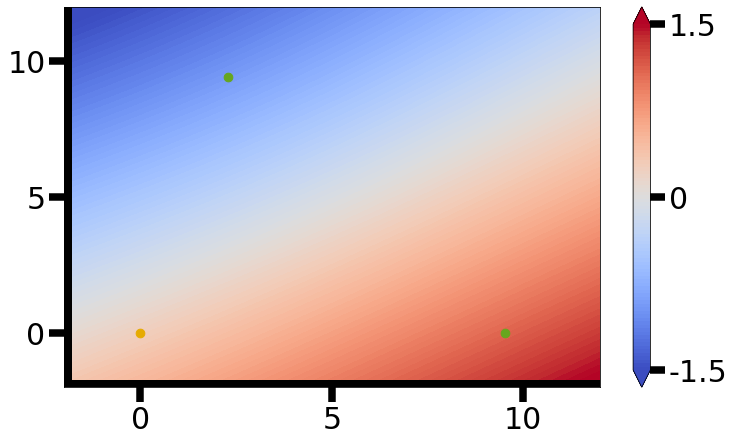

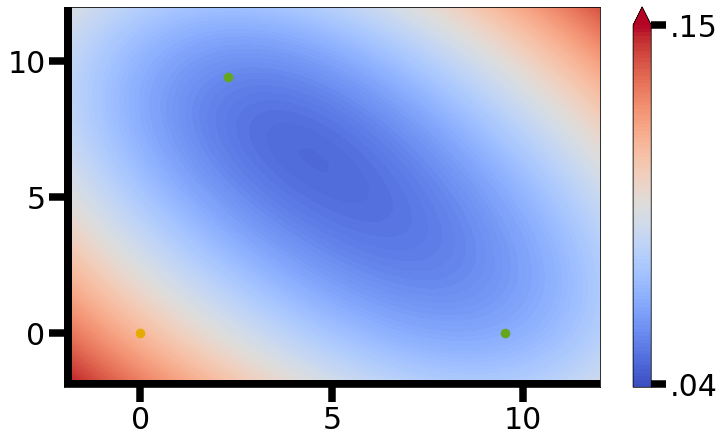

Working on **ana_relu_2l** ...

Investiagting **ana_relu_2l**

  0%|          | 0/4900 [00:00<?, ?it/s]

Kernel computation took 7.587323 seconds.

**Test accuracy**: 99.12%

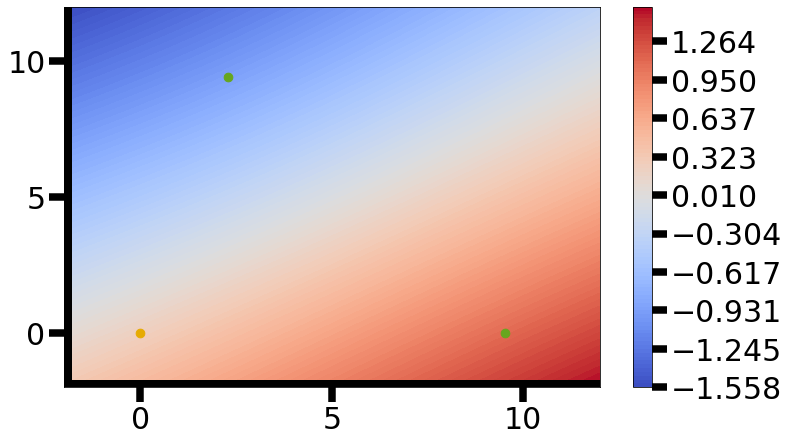

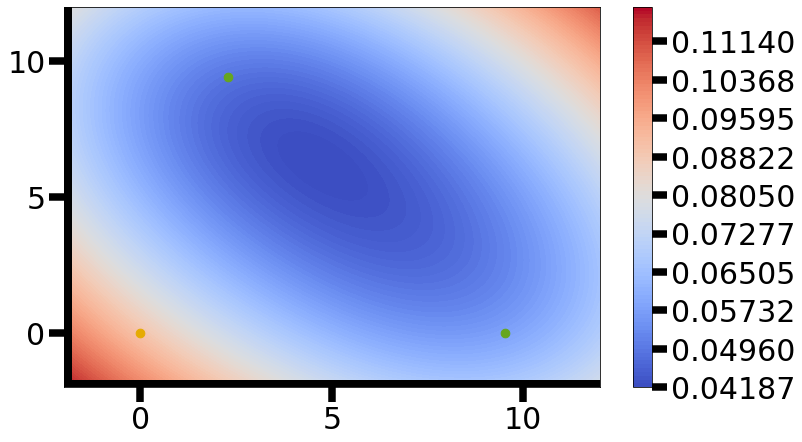

Working on **ana_relu_4l** ...

Investiagting **ana_relu_4l**

  0%|          | 0/4900 [00:00<?, ?it/s]

Kernel computation took 7.696099 seconds.

**Test accuracy**: 99.12%

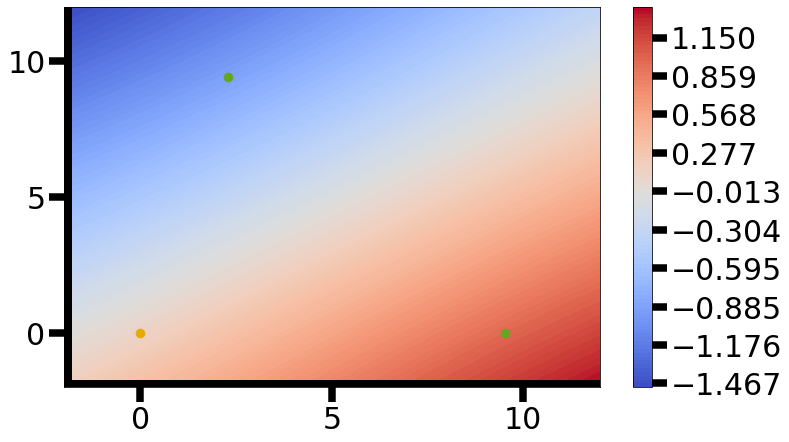

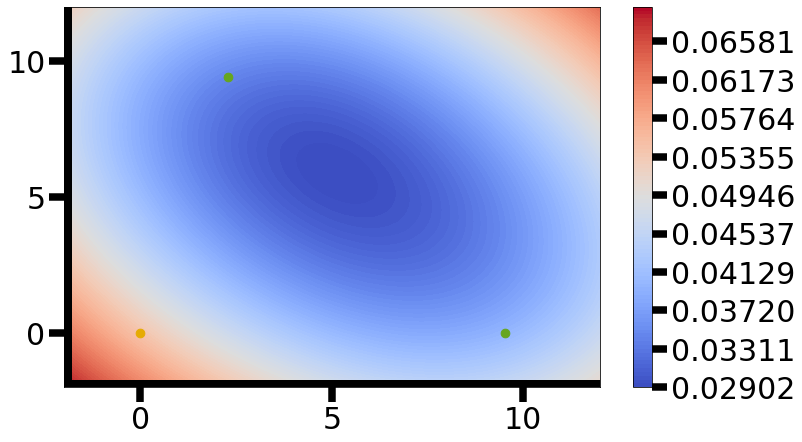

Working on **ana_erf_1l** ...

Investiagting **ana_erf_1l**

  0%|          | 0/4900 [00:00<?, ?it/s]

Kernel computation took 7.344663 seconds.

**Test accuracy**: 99.12%

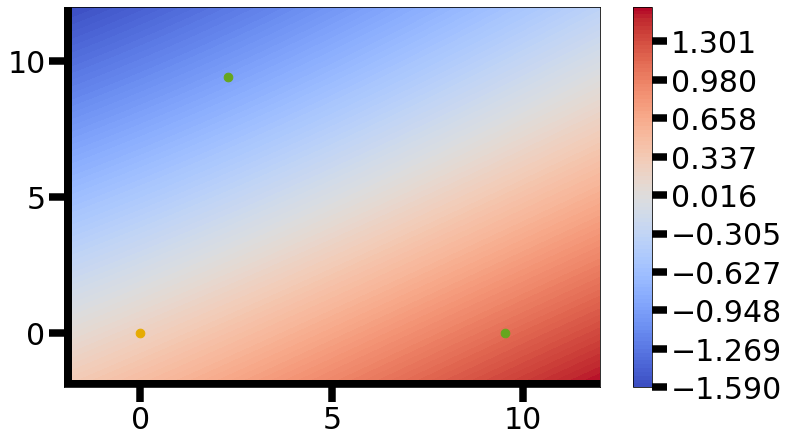

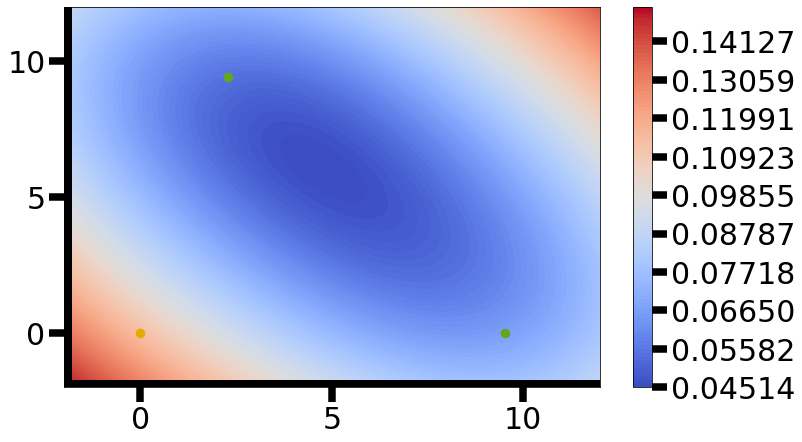

Working on **ana_erf_2l** ...

Investiagting **ana_erf_2l**

  0%|          | 0/4900 [00:00<?, ?it/s]

Kernel computation took 7.576091 seconds.

**Test accuracy**: 99.12%

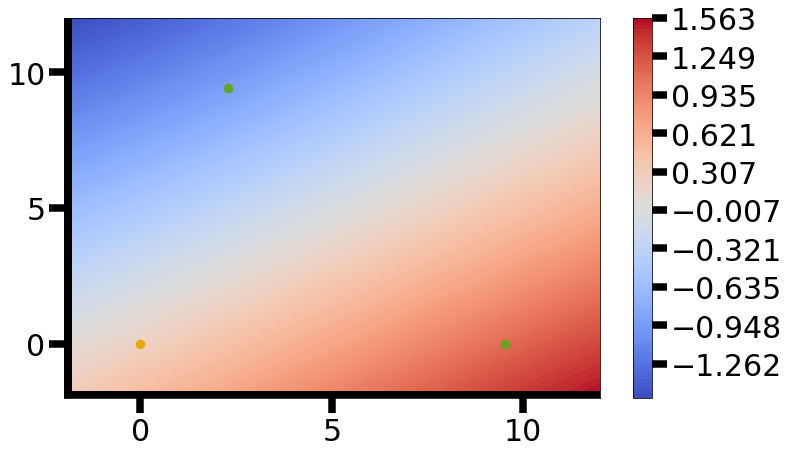

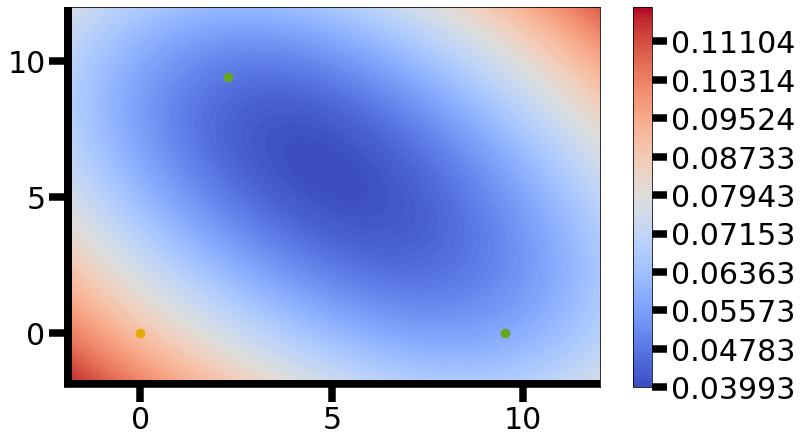

Working on **ana_erf_4l** ...

Investiagting **ana_erf_4l**

  0%|          | 0/4900 [00:00<?, ?it/s]

Kernel computation took 7.519938 seconds.

**Test accuracy**: 99.12%

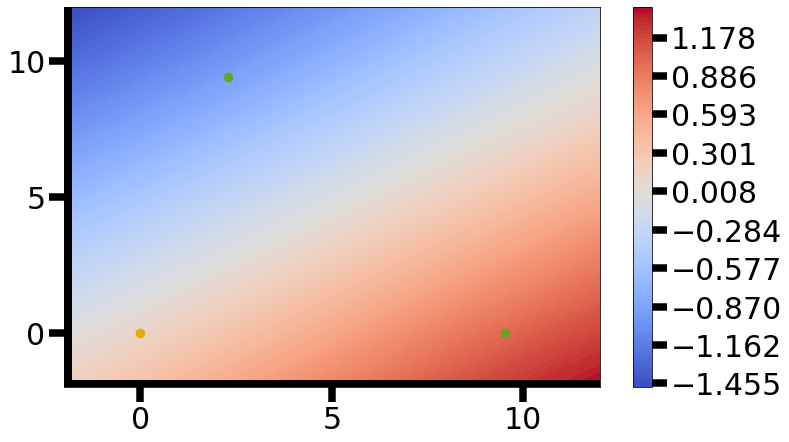

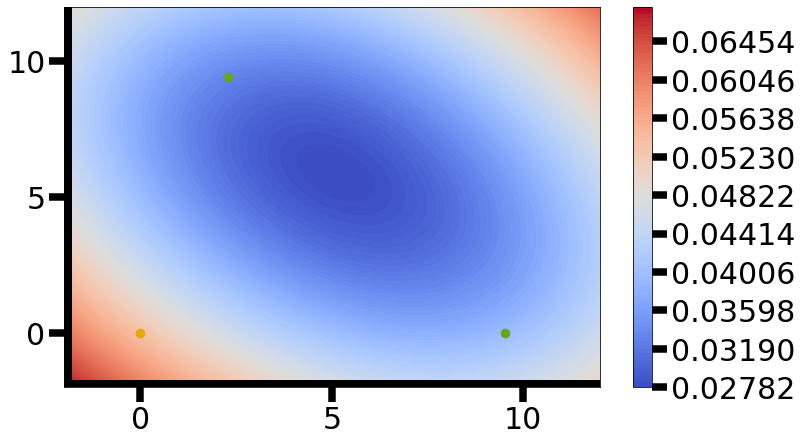

Working on **ana_cos_1l** ...

Investiagting **ana_cos_1l**

  0%|          | 0/4900 [00:00<?, ?it/s]

Kernel computation took 9.572636 seconds.

**Test accuracy**: 99.12%

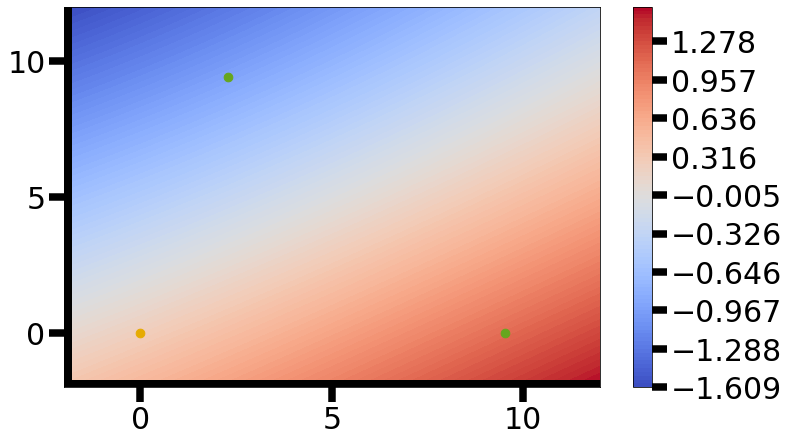

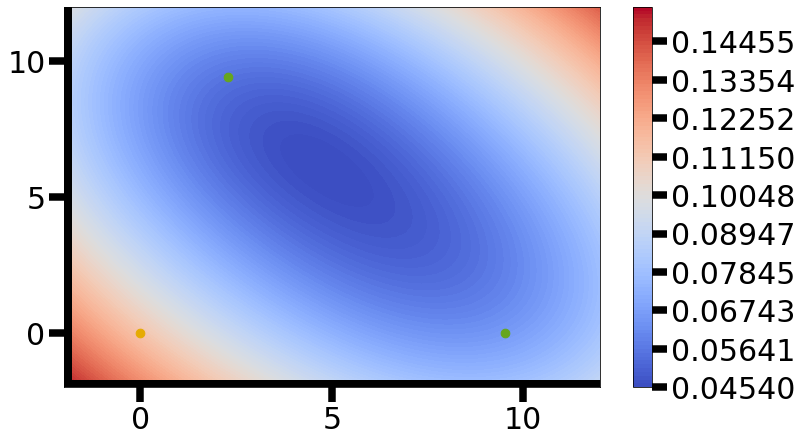

Working on **ana_cos_1l_sw_medium** ...

Investiagting **ana_cos_1l_sw_medium**

  0%|          | 0/4900 [00:00<?, ?it/s]

Kernel computation took 9.527372 seconds.

**Test accuracy**: 99.12%

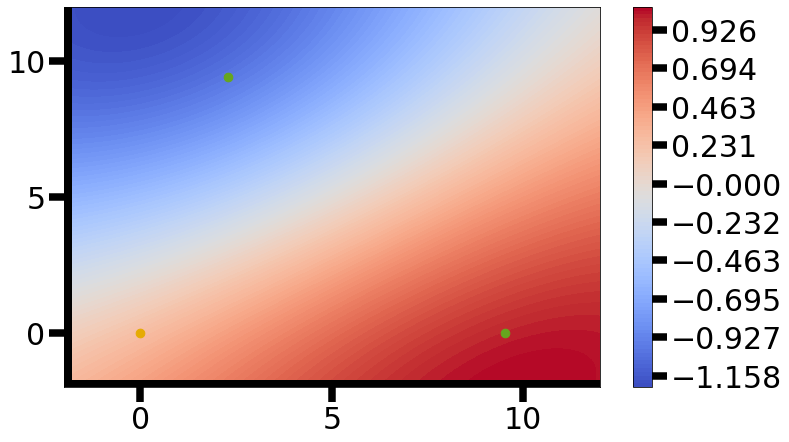

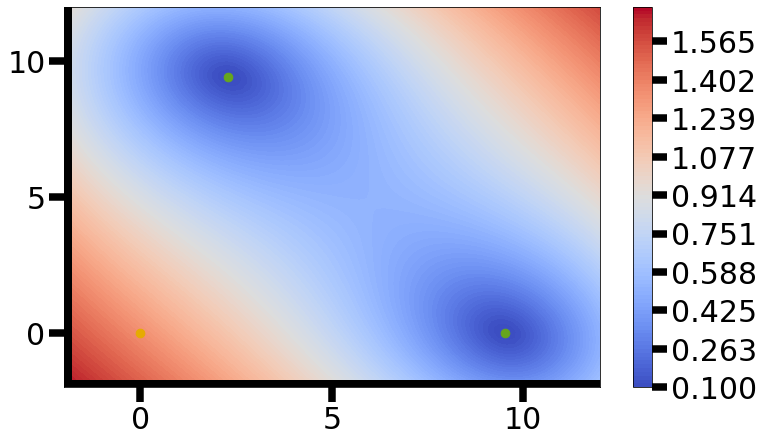

Working on **ana_cos_1l_sw_large** ...

Investiagting **ana_cos_1l_sw_large**

  0%|          | 0/4900 [00:00<?, ?it/s]

Kernel computation took 9.588639 seconds.

**Test accuracy**: 99.12%

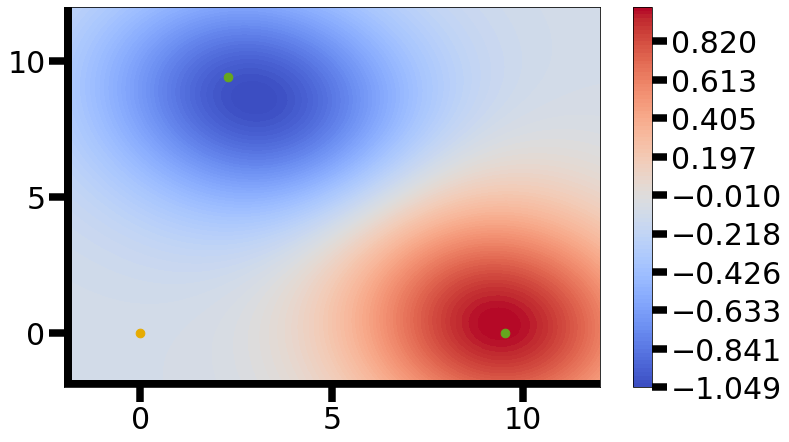

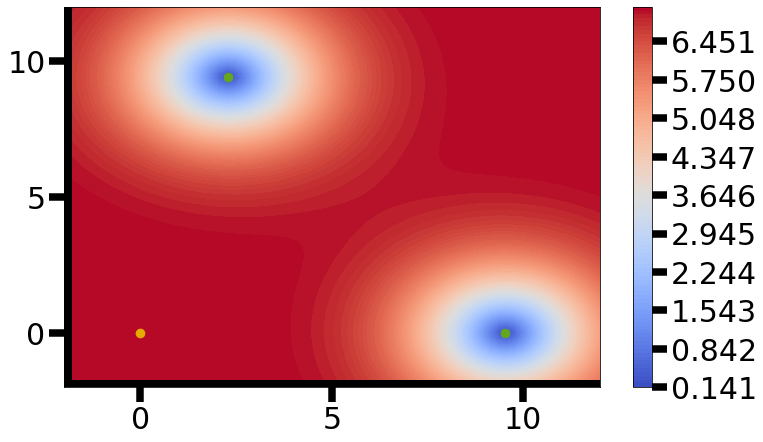

Working on **rbf_ls_medium** ...

Investiagting **rbf_ls_medium**

  0%|          | 0/4900 [00:00<?, ?it/s]

Kernel computation took 5.972100 seconds.

**Test accuracy**: 99.12%

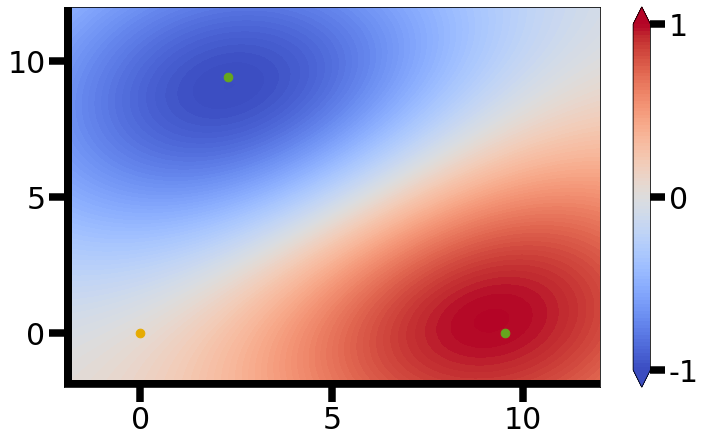

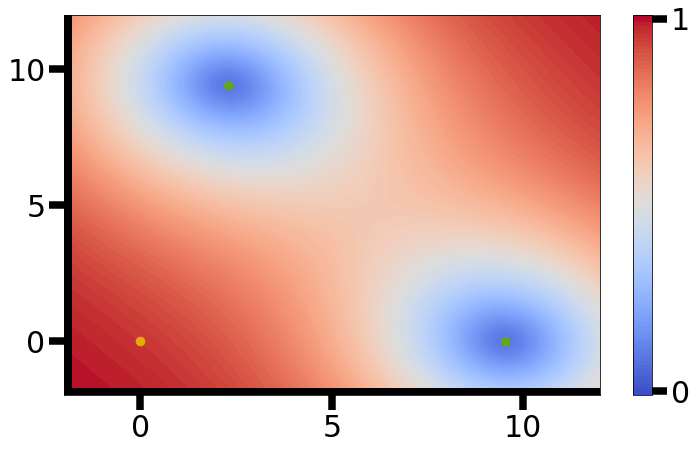

In [18]:
with torch.no_grad():
    for i, k_props in enumerate(kernel_properties):
        display(Markdown('Working on **%s** ...' % (k_props['name']))) 

        [p1, p2, p3] = k_props['plane_points']
        [(_, x, y), coords] = k_props['plane_specs']
        
        nngp_grid_props = [dict(k_props)]
        
        det_func = nutils.determine_mlp_kernel_func
        if k_props['type'] == 'none':
            det_func = nutils.determine_classic_kernel_func
        grid_nd = grid_2d_to_nd(grid_X, (p3, x, y))
        grid_torch = torch.from_numpy(grid_nd).float().to(device)
        nutils.compute_kernel_values(nngp_grid_props, grid_torch, X_train, Y_train,
                                     det_func, test_bs=500,
                                     out_dir=config.out_dir, try_inference=False)

        k_props = nngp_grid_props[0]
        
        heatmap_kwargs['data_in'] = coords
        heatmap_kwargs['data_trgt'] = np.array([-1, -1, 1])
        
        if 'K_train' not in k_props.keys():
            continue

        K_train = k_props['K_train']
        K_test = k_props['K_test']
        K_all = k_props['K_all']

        try:
            grid_mean, grid_var = inference_with_isotropic_gaussian_ll( \
                Y_train, K_train, K_test, K_all, var=likelihood_var)
        except:
            L, ll_var = cholesky_adaptive_noise(K_train, var=likelihood_var, var_step=1.1)
            display(Markdown('**WARN** Have to use higher ll variance %f for **%s**.' \
                             % (ll_var, k_props['name'])))
            test_mean, test_var = inference_with_isotropic_gaussian_ll( \
                Y_train, K_train, K_test, K_all, L_mat=L, var=ll_var)

        def check_nan(tensor, ident):
            if torch.any(torch.isnan(tensor)):
                nan_mask = torch.isnan(tensor)
                display(Markdown('**%d NaN values in %s.**' \
                        % (nan_mask.sum(), ident)))
                tensor[nan_mask] = 0

        check_nan(test_mean, 'predictive mean')
        check_nan(test_var, 'predictive variance')

        display(Markdown('**Test accuracy**: %.2f%%' \
              % compute_accuracy(Y_test, test_mean)))
        
        grid_std = torch.sqrt(grid_var.cpu())
        
        if k_props['name'] == 'rbf_ls_medium' and setting == 'use_ind_highest_unc':
            heatmap(grid_mean, title='Posterior Predictive Mean - %s' % (k_props['name']),
                    vmin=-1, vmax=1, force_extend='both', cticks=[-1, 0, 1], 
                    ctick_lbls=['-1', '0', '1'], filename='post_mean_%s_%s' % (k_props['name'], setting),
                    **heatmap_kwargs) 

            heatmap(grid_std, title='Posterior Predictive Std - %s' % (k_props['name']),
                    vmin=0, vmax=1., force_extend='neither', cticks=[.01, .99],
                    ctick_lbls=['0', '1'], filename='post_std_%s_%s' % (k_props['name'], setting),
                    **heatmap_kwargs)
            
        elif k_props['name'] == 'rbf_ls_medium' and setting == 'use_ood_lowest_unc':
            heatmap(grid_mean, title='Posterior Predictive Mean - %s' % (k_props['name']),
                    vmin=-1, vmax=1, force_extend='both', cticks=[-1, 0, 1], 
                    ctick_lbls=['-1', '0', '1'], filename='post_mean_%s_%s' % (k_props['name'], setting),
                    **heatmap_kwargs) 

            heatmap(grid_std, title='Posterior Predictive Std - %s' % (k_props['name']),
                    vmin=0, vmax=.8, force_extend='max', cticks=[.0075, .795],
                    ctick_lbls=['0', '.8'], filename='post_std_%s_%s' % (k_props['name'], setting),
                    **heatmap_kwargs)
            
        elif k_props['name'] == 'ana_relu_1l' and setting == 'use_ind_highest_unc':
            heatmap(grid_mean, title='Posterior Predictive Mean - %s' % (k_props['name']),
                    vmin=-1.5, vmax=1.5, force_extend='both', cticks=[-1.5, 0, 1.5], 
                    ctick_lbls=['-1.5', '0', '1.5'], filename='post_mean_%s_%s' % (k_props['name'], setting),
                    **heatmap_kwargs) 

            heatmap(grid_std, title='Posterior Predictive Std - %s' % (k_props['name']),
                    vmin=.04, vmax=.15, force_extend='max', cticks=[.041, .15],
                    ctick_lbls=['.04', '.15'], filename='post_std_%s_%s' % (k_props['name'], setting),
                    **heatmap_kwargs)
            
        elif k_props['name'] == 'ana_relu_1l' and setting == 'use_ood_lowest_unc':
            heatmap(grid_mean, title='Posterior Predictive Mean - %s' % (k_props['name']),
                    vmin=-1.3, vmax=1.3, force_extend='both', cticks=[-1.3, 0, 1.3], 
                    ctick_lbls=['-1.3', '0', '1.3'], filename='post_mean_%s_%s' % (k_props['name'], setting),
                    **heatmap_kwargs) 

            heatmap(grid_std, title='Posterior Predictive Std - %s' % (k_props['name']),
                    vmin=.03, vmax=.09, force_extend='both', cticks=[.03, .09],
                    ctick_lbls=['.03', '.09'], filename='post_std_%s_%s' % (k_props['name'], setting),
                    **heatmap_kwargs)
            
        else:
            heatmap(grid_mean, title='Posterior Predictive Mean - %s' % (k_props['name']),
                    **heatmap_kwargs) 

            heatmap(grid_std, title='Posterior Predictive Std - %s' % (k_props['name']),
                    **heatmap_kwargs)

Working on **ana_relu_1l** ...

[[5.  6.3]]


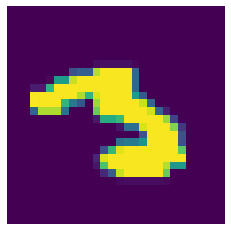

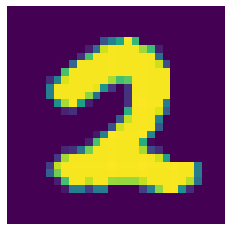

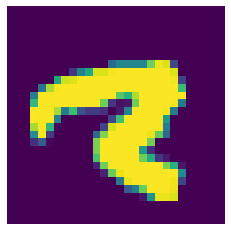

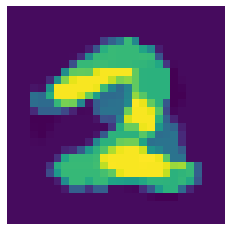

Working on **ana_relu_2l** ...

Working on **ana_relu_4l** ...

Working on **ana_erf_1l** ...

Working on **ana_erf_2l** ...

Working on **ana_erf_4l** ...

Working on **ana_cos_1l** ...

Working on **ana_cos_1l_sw_medium** ...

Working on **ana_cos_1l_sw_large** ...

Working on **rbf_ls_medium** ...

[[10 10]]


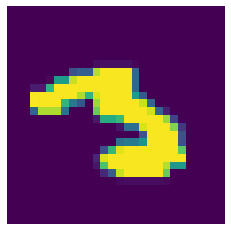

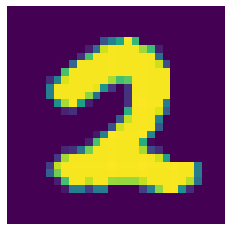

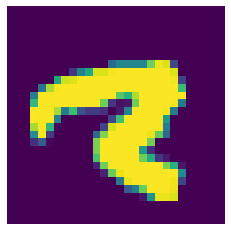

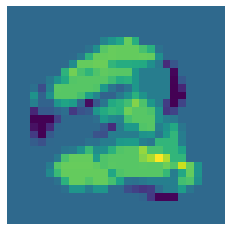

In [20]:
# Choose another random image to be plotted on the 2D plane.

#%%script false --no-raise-error # Do not execute cell.

with torch.no_grad():
    for i, k_props in enumerate(kernel_properties):
        display(Markdown('Working on **%s** ...' % (k_props['name']))) 

        [p1, p2, p3] = k_props['plane_points']
        [(_, x, y), coords] = k_props['plane_specs']
        
        if setting == 'use_ind_highest_unc':
            if k_props['name'] == 'rbf_ls_medium':
                coord_rand = np.array([10,10]).reshape(1, 2)
            elif k_props['name'] == 'ana_relu_1l':
                coord_rand = np.array([5,6.3]).reshape(1, 2)
            else:
                continue
        elif setting == 'use_ood_lowest_unc':
            if k_props['name'] == 'rbf_ls_medium':
                coord_rand = np.array([5,5]).reshape(1, 2)
            elif k_props['name'] == 'ana_relu_1l':
                coord_rand = np.array([1.5,1.5]).reshape(1, 2)
            else:
                continue
        else:
            continue
            
        print(coord_rand)
            
        rand_img = grid_2d_to_nd(coord_rand, (p3, x, y))
        # Renormalize
        rand_img = (-rand_img.min() + rand_img) / \
            (rand_img.max() - rand_img.min())
        
        for i, pp in enumerate([p1, p2, p3, rand_img]):
            plt.imshow(pp.reshape(28,28))
            plt.gca().set_axis_off()

            fpath = 'img_%d_%s' % (i, setting)
            fpath = os.path.join(config.out_dir, fpath)
            plt.savefig(fpath + '.png', bbox_inches='tight')

            plt.show()